In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR, LambdaLR
import sympy as sp

In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [3]:
loaded_data = torch.load('hold_data.pth')

x_values = loaded_data['x_values'].to(device)
y_values = loaded_data['y_values'].to(device)
derivatives = loaded_data['derivatives'].to(device)
params = loaded_data['param_values'].to(device)
functions = loaded_data['formulas']
symbols = loaded_data['symbols']
num_params = loaded_data['num_params'].to(device)
function_labels = loaded_data['function_labels'].to(device)
#hessians = torch.load('hold_other.pth')['hessians'].to(device)


/tmp/ipykernel_529990/343381410.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_data = torch.load('hold_data.pth')


In [4]:
print(f"x_values: {x_values.shape}")
print(f"y_values: {y_values.shape}")
print(f"derivatives: {derivatives.shape}")
#print(f"hessians: {hessians.shape}")
print(f"param_values: {params.shape}")
print(f"formulas: {len(functions)}")
print(f"symbols: {len(symbols)}")
print(f"num_params: {num_params.shape}")
print(f"function_labels: {function_labels.shape}")

x_values: torch.Size([100])
y_values: torch.Size([10000, 100])
derivatives: torch.Size([10000, 100, 5])
param_values: torch.Size([10000, 5])
formulas: 10
symbols: 10
num_params: torch.Size([10])
function_labels: torch.Size([10000])


In [5]:
'''h = hessians.flatten(1,2)
d = derivatives.flatten(1,2)
d = F.pad(d, (0,h.shape[1]-d.shape[1]))
y = F.pad(y_values, (0,h.shape[1]-y_values.shape[1]))'''
d = derivatives.flatten(1,2)
y = F.pad(y_values, (0,d.shape[1]-y_values.shape[1]))
input_data = torch.stack([d,y], dim=2)

In [6]:
class Multi_Func_Channels(nn.Module):
    def __init__(self, functions, num_params, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions
        self.x_data = x_data.to(self.device)
        self.input_channels = input_channels
        self.num_params = num_params
        self.max_params = max(num_params)
        self.total_params = sum(self.num_params)
        self.symbols = symbols
        self.epsilon = 1e-4

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128),
            nn.SELU(),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, self.total_params),
        )

    def evaluate(self, params, index):
        symbols = self.symbols[index]
        formula = self.functions[index]
        x = self.x_data
        var_values = {str(symbols[j]): params[:, j] for j in range(len(symbols)-1)}
        eval_func = sp.lambdify(symbols, formula, modules="numpy")
        #results = []
        #for xi in x:
        var_values[str(symbols[-1])] = x.unsqueeze(1)
            #np_values = {str(sym): var_values[sym].detach().cpu().numpy() for sym in symbols}
        results = eval_func(**var_values)
        results = torch.nan_to_num(results, 0)
        #results.append(eval_func(**var_values))
        #tensor_results = [torch.tensor(r, device=device) for r in results]
        return results.swapaxes(0,1)
    
    def derivative(self, params, index):
        derivatives = torch.zeros((params.shape[0], self.x_data.shape[0], self.max_params))
        params_n = params.clone().detach().requires_grad_(True)
        for p in range(len(symbols[index])-1):
            plus = params_n.clone()
            minus = params_n.clone()
            plus[:,p] += self.epsilon
            forward_values = self.evaluate(plus, index)
            minus[:, p] -= self.epsilon
            backward_values = self.evaluate(minus, index)
            derivatives[:, :, p] = (forward_values - backward_values) / (2 * self.epsilon)
        return derivatives.flatten(1,2)


    '''def hessian(self, params, index):
        params.requires_grad_(True)
        y = self.evaluate(params, index)
        grad = torch.autograd.grad(y.sum(), params, create_graph=True)[0]
        return torch.stack([torch.autograd.grad(g, params, retain_graph=True)[0] for g in grad.flatten()]).reshape(params.shape + params.shape)'''


    def hessian(self, params, index):
        hessians = torch.zeros((params.shape[0], self.x_data.shape[0], self.max_params, self.max_params))
        params_f = params.clone().detach().requires_grad_(True)
        for j in range(len(symbols[index])-1):
            for k in range(len(symbols[index])-1):
                plus_plus = params_f.clone()
                plus_minus = params_f.clone()
                minus_plus = params_f.clone()
                minus_minus = params_f.clone()

                plus_plus[:, j] += self.epsilon
                plus_plus[:, k] += self.epsilon

                plus_minus[:, j] += self.epsilon
                plus_minus[:, k] -= self.epsilon

                minus_plus[:, j] -= self.epsilon
                minus_plus[:, k] += self.epsilon

                minus_minus[:, j] -= self.epsilon
                minus_minus[:, k] -= self.epsilon

                forward_forward = self.evaluate(plus_plus, index)
                forward_backward = self.evaluate(plus_minus, index)
                backward_forward = self.evaluate(minus_plus, index)
                backward_backward = self.evaluate(minus_minus,index)
                hessians[:, :, j, k] = (forward_forward - forward_backward - backward_forward + backward_backward) / (4 * self.epsilon **2)
        return hessians.flatten(1,3)
    
    def loss_func(self, outputs, targets):
        losses = []
        outputs = outputs.permute(2,0,1)
        targets = targets.permute(2,0,1)
        for output, target in zip(outputs, targets):
            loss = torch.mean(((target - output) ** 2), dim=1)
            losses.append(loss)
        total_losses = torch.mean(torch.stack(losses), dim=0)
        #l2_reg = sum(p.pow(2.0).sum() for p in self.parameters())
        #l1_reg = sum(p.abs().sum() for p in self.parameters())
        #total_losses += 0.01 * l2_reg + 0.01 * l1_reg
        return total_losses

    def forward(self, inputs):
        target = inputs.squeeze(dim=2)
        outs = torch.swapaxes(inputs, 1, 2).to(self.device)
        outs = self.hidden_x1(outs)
        xfc = torch.reshape(outs, (-1, 256))
        xfc = self.hidden_xfc(xfc)

        outs = torch.reshape(outs, (-1, 2, 128))
        outs = self.hidden_x2(outs)
        cnn_flat = self.flatten_layer(outs)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        start_index = 0
        losses = []
        outputs = []
        preds = []
        pred_params = []
        #hessians =[]

        for f in range(len(self.functions)):
            params = embedding[:, start_index:start_index+self.num_params[f]]
            pred_params.append(params)
            y_vals = self.evaluate(params, f).to(self.device)
            d_vals = self.derivative(params, f).to(self.device)
            #h_vals = self.hessian(params, f).to(self.device)
            #hessians.append(h_vals)
            #d_vals = F.pad(d_vals, (0,h_vals.shape[1]-d_vals.shape[1]))
            #y_vals = F.pad(y_vals, (0,h_vals.shape[1]-y_vals.shape[1]))
            #d_vals = F.pad(d_vals, (0,2500-d_vals.shape[1]))
            y_vals = F.pad(y_vals, (0,d_vals.shape[1]-y_vals.shape[1]))
            #y_vals = F.pad(y_vals, (0,d_vals.shape[1]-y_vals.shape[1]))
            # output = torch.stack([h_vals,d_vals,y_vals], dim=2).to(self.device)
            output = torch.stack([d_vals,y_vals], dim=2).to(self.device)
            outputs.append(output)
            preds.append(y_vals)
            loss = self.loss_func(output, target)
            losses.append(loss)
            start_index += self.num_params[f]  
        stacked_losses = torch.stack(losses).to(self.device)
        stacked_preds = torch.stack(preds).to(self.device)
        best_loss, best_indexes = torch.min(stacked_losses, dim=0)
        best_out = stacked_preds[best_indexes, -1]
        best_func = [self.functions[idx] for idx in best_indexes]
        best_params = []
        for index, value in enumerate(best_indexes):
            best_params.append(pred_params[value][index])
        return best_out, best_loss, best_func, best_indexes, best_params, stacked_preds, stacked_losses, pred_params

In [39]:
def training_loss_func(model, l_val, output_y, target_y, output_func, target_func):
    target_max = torch.max(target_y, dim=-1, keepdim=True)[0]
    target_min = torch.min(target_y, dim=-1, keepdim=True)[0]
    target_range = torch.clamp(target_max - target_min, min=1e-6).squeeze(-1)

    # YIKES LOSS FOR Y VALUES IS STILL KINDA HIGH
    mse_loss_y = torch.mean(torch.mean((output_y - target_y) ** 2, dim=1)/target_range)
    mse_loss_func = (output_func == target_func).float().mean()
    print(f"mse_loss_y: {mse_loss_y}")
    print(f"mse_loss_func: {mse_loss_func}")
    total_loss = (mse_loss_y*(1-l_val)) + (mse_loss_func*l_val)

    #normalized_loss = mse_loss / target_range
    
    #l2_reg = sum(p.pow(2.0).sum() for p in model.parameters())
    #l1_reg = sum(p.abs().sum() for p in model.parameters())    
    #total_loss = torch.mean(normalized_loss) + 0.01 * l2_reg + 0.01 * l1_reg
    return total_loss


In [40]:
model = Multi_Func_Channels(functions=functions, num_params=num_params, x_data=x_values, input_channels=2, device=device).to(device)
dataset = torch.utils.data.TensorDataset(input_data, function_labels)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

total_epochs = 50

def lambda_rule(epoch):
    start_lambda = 0.9999999999*100
    end_lambda = 0.5*100
    return start_lambda - (start_lambda - end_lambda) * min(epoch / total_epochs, 1.0)

optimizer = optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
l_val_sched = LambdaLR(optimizer, lr_lambda=lambda_rule)
# loss_func = nn.MSELoss()

for epoch in range(total_epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 1
    model.train()
    
    for train, labels in dataloader:
        train = train.requires_grad_(True).to(device)
        optimizer.zero_grad()
        best_out, best_loss, best_func, best_indexes, best_params, stacked_preds, stacked_losses, pred_params = model(train)
        lambda_val = l_val_sched.get_last_lr()[0]
        print(lambda_val)
        loss = training_loss_func(model, lambda_val, best_out, train[:,:,0], best_indexes, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    l_val_sched.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{total_epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

0.9999999999
mse_loss_y: 160.15536499023438
mse_loss_func: 0.6390000581741333
0.9999999999
mse_loss_y: 327.66058349609375
mse_loss_func: 0.6260000467300415
0.9999999999
mse_loss_y: 116.09902954101562
mse_loss_func: 0.6070000529289246
0.9999999999
mse_loss_y: 594.4959716796875
mse_loss_func: 0.6210000514984131
0.9999999999
mse_loss_y: 132.809326171875
mse_loss_func: 0.6140000224113464
0.9999999999
mse_loss_y: 1490.6080322265625
mse_loss_func: 0.6240000128746033
0.9999999999
mse_loss_y: 382.6678466796875
mse_loss_func: 0.6190000176429749
0.9999999999
mse_loss_y: 637.5678100585938
mse_loss_func: 0.6210000514984131
0.9999999999
mse_loss_y: 1181.79150390625
mse_loss_func: 0.5940000414848328
0.9999999999
mse_loss_y: 394.4088439941406
mse_loss_func: 0.6360000371932983
epoch : 0/50, loss = 0.62003810
--- 9.83810567855835 seconds ---
0.9899999999019999
mse_loss_y: 953.0667724609375
mse_loss_func: 0.609000027179718
0.9899999999019999
mse_loss_y: 423.1591796875
mse_loss_func: 0.10600000619888306


KeyboardInterrupt: 

In [198]:
torch.save(model.state_dict(), 'model.pth')

In [194]:
other_model = torch.load('model.pth')

/tmp/ipykernel_2201610/2087370462.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  other_model = torch.load('model.pth')


best_func: [a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c, a*x**2 + b*x + c

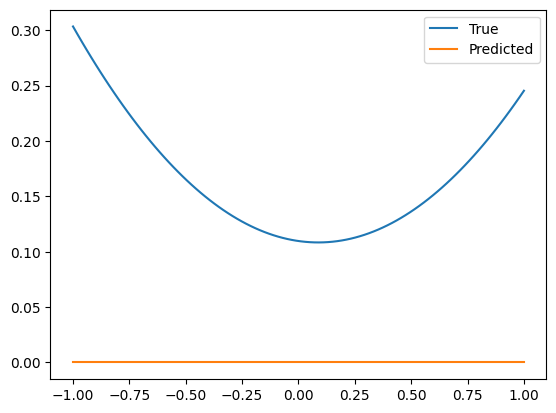

In [147]:
model.eval()
ran = np.random.randint(0, 100)
best_out, best_loss, best_func, best_indexes, best_params, stacked_preds, stacked_losses, pred_params = model(input_data[5000:10000])
print(f"best_func: {best_func}")
print(f"best_loss: {best_loss}")
# GETTING NAN PARAMS IN EVALUATION MODE OH NOOO
print(f"best_params: {best_params}")
plt.plot(x_values.detach().cpu().numpy(), y_values[ran].detach().cpu().numpy(), label='True')
plt.plot(x_values.detach().cpu().numpy(), best_out[ran][0:100].detach().cpu().numpy(), label='Predicted')
plt.legend()